# Creation ontologies

Here, we create ontologies of the items contained in the scales using different approaches.

In the first approach, we use the embeddings given by the large language model directly. 
In the second approach, we compute an embedding of these embeddings so as to capture the relationships that are intrinsic to the set, instead of those of the corpus used to train the large language model. The idea is to use a diffusion kernel to clean up the similariy graph. These different approaches create alternative ontologies that are saved for evaluation.

In [2]:
import pandas as pd
import numpy as np
import phate
import scipy.spatial.distance as distance

# Here the scaled with the embeddings are loaded. Change the file to load
# embeddings from a different language model.
scales = pd.read_csv('scales_openAI.csv')

# select the rows of scales where the scaleID field is "NEO" or "PID"
scales = scales[scales['scaleID'].isin(['NEO', 'PID'])]

# form matrix of embeddings
mx = scales.embedding.apply(eval).to_list()
mx = np.asarray(mx)

# load scales data
data = pd.read_csv('scales_data.csv')

# select the columns of the dataframe data where the column names starts with "PID" or "NEO"
data = data[data.columns[data.columns.str.startswith('PID') | data.columns.str.startswith('NEO')]]

# form the correlation matrix of the scales data
corr_mx = data.corr().values
corr_values = distance.squareform(1 - corr_mx)

# extract the upper triangle of a matrix into a vector
def extract_upper_triangle(matrix):
    n = matrix.shape[0]
    return matrix[np.triu_indices(n, 1)]
corr_values = extract_upper_triangle(corr_mx)

The first approach is to use the language model ebeddings directly.

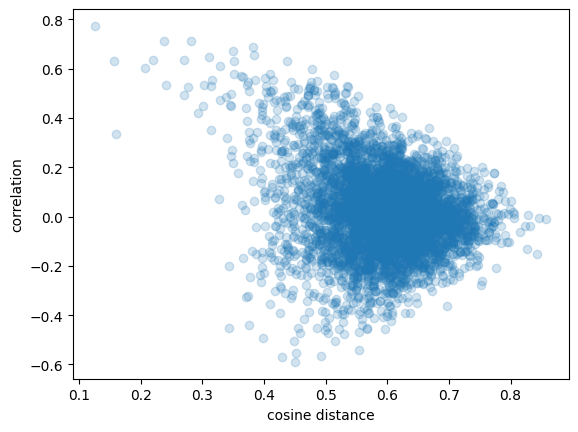

In [108]:

# Create a distance matrix from the data matrix mx
dist_values = distance.pdist(mx, metric='cosine')
dist_mx = distance.squareform(dist_values)

# Print a scatter plot of of dist_values and corr_values
import matplotlib.pyplot as plt
plt.scatter(dist_values, corr_values, alpha = 0.2)
plt.xlabel('cosine distance')
plt.ylabel('correlation')
plt.show()


We can see that item pairs that have a small cosine distance (i.e. are similar) also have a high correlation. A cosine distance of 0.2 or lower is a guarantee that responses are correlated with a coefficient of 0.6 or more. There are also some item pairs with relatively small distance that have a negative correlation, but we note that the NEO goes in the opposite direction than the PID except for neuroticism.

What is of interest from the standpoint of the scales, however, is to assess the extent to which the two scales are semantically related. For this, we only consider the distance between items of the first and the second scale, rather than all scale items with each other.

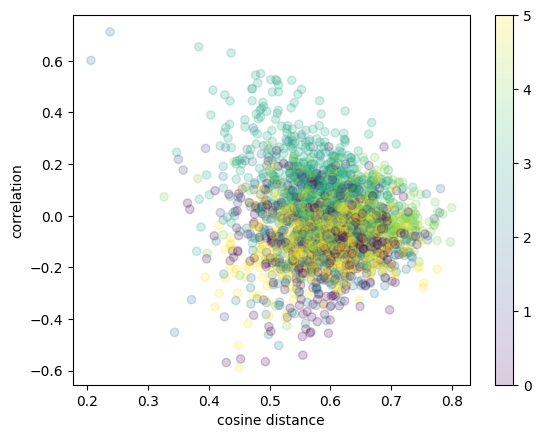

In [20]:
# select rows of mx where scales.scaleID is "NEO"
neo_idx = scales['scaleID'] == 'NEO'
pid_idx = scales['scaleID'] == 'PID'
neo_mx = mx[neo_idx, :]
pid_mx = mx[pid_idx, :]
cdist_mx = distance.cdist(neo_mx, pid_mx, metric='cosine')
ccorr_mx = corr_mx[np.ix_(neo_idx,pid_idx)]

#create color colorcodes
neo_type = pd.Categorical(scales[neo_idx]['type'].values)
neo_codes = neo_type.codes
#create a matrix of the same size as ccorr_mx with the colorcodes
color_mx = np.zeros(ccorr_mx.shape)
color_mx = color_mx + neo_type.codes[:, np.newaxis]

import matplotlib.pyplot as plt
plt.scatter(cdist_mx.flatten(), ccorr_mx.flatten(), alpha = 0.2,
            c = color_mx.flatten(), cmap = 'viridis')
# add color legend to plot, mapping colors to the name of the NEO scale
plt.colorbar()

plt.xlabel('cosine distance')
plt.ylabel('correlation')
plt.show()


We see here that, as the semantic similarity increases (lower cosine distances between the language model embeddings), the correlation can take considerable values, although there are also cases where the correlation is low and the distance is lower than that. Cosine distances of 0.6 or more are required to keep the correlation within the +-0.2 boundaries.

Furthermore, we see that the points showing a positive correlation with the PID scores are the green points, which belong to the subscale neuroticism. The violet and yellow points with negative correlations are extraversion and agreeableness. We would expect neuroticism to provide positive correlations with PID items since they are the only ones in the NEO inventory that go in the same direction as the PID items (higher scores mean more pathology). We would also expect positive NEO items to show less semantic relatedness to the PID items, as opposites even if related do not quite have the same meaning.

## PHATE

In the second approach, we use phate to estimate a diffusion kernel, and then we use the distances from that kernel to form the ontology.

In [ ]:
phate_operator = phate.PHATE(n_jobs = -2, gamma = -1, decay = 80, knn = 3, t = 1, n_components = 63, 
                             mds_dist='euclidean', mds = 'nonmetric', mds_solver = 'smacof') 
Y_phate = phate_operator.fit_transform(mx)

# Create a distance matrix from the data matrix mx
dist_values = distance.pdist(Y_phate, metric='euclidean')
dist_mx = distance.squareform(dist_values)


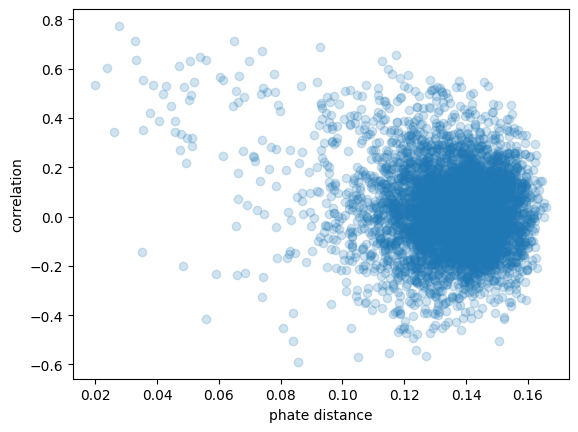

In [139]:

# Print a scatter plot of of dist_values and corr_values
import matplotlib.pyplot as plt
plt.scatter(dist_values, corr_values, alpha = 0.2)
plt.xlabel('phate distance')
plt.ylabel('correlation')
plt.show()

We obtain this result after modifying the default settings for phate. The most important changes are: 1. diffusion degrades the definition of distance and high correlation in data (hence, t = 1), 2. many dimensions are required (to do: use von Neumann entropy to automatically determine dimensions). Alpha decay, in contrast, improves performance (but not by much), as does a small neighbourhood.

This result appears to separate the items with high correlation a bit more from the buld. However, also a few items with no correlation are considered semantically similar. We also do not have the clear association between cosine distance and correlation we had in the raw data. In sum, the geometry of the semantic distance is altered such that distance is no longer a good predictor of correlation of responses.